## Distance Metrics

The current tutorial shows the building block of these larger methods, which are a small suite of distance metrics. Set up a small corpus consisting of documents belonging to one of two topics

In [1]:
from gensim.corpora import Dictionary

# you can use any corpus, this is just illustratory
texts = [
    ['bank','river','shore','water'],
    ['river','water','flow','fast','tree'],
    ['bank','water','fall','flow'],
    ['bank','bank','water','rain','river'],
    ['river','water','mud','tree'],
    ['money','transaction','bank','finance'],
    ['bank','borrow','money'],
    ['bank','finance'],
    ['finance','money','sell','bank'],
    ['borrow','sell'],
    ['bank','loan','sell'],
]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

import numpy
numpy.random.seed(1) # setting random seed to get the same results each time.

from gensim.models import ldamodel
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2, minimum_probability=1e-8)
model.show_topics()

[(0,
  '0.207*"bank" + 0.100*"water" + 0.089*"river" + 0.088*"sell" + 0.067*"borrow" + 0.064*"finance" + 0.062*"money" + 0.053*"tree" + 0.045*"flow" + 0.044*"rain"'),
 (1,
  '0.142*"bank" + 0.116*"water" + 0.090*"river" + 0.084*"money" + 0.081*"finance" + 0.064*"flow" + 0.055*"transaction" + 0.055*"tree" + 0.053*"fall" + 0.050*"mud"')]

Let’s call the 1st topic the water topic and the second topic the finance topic.

Let’s take a few sample documents and get them ready to test our distance functions.

In [2]:
doc_water = ['river', 'water', 'shore']
doc_finance = ['finance', 'money', 'sell']
doc_bank = ['finance', 'bank', 'tree', 'water']

# now let's make these into a bag of words format
bow_water = model.id2word.doc2bow(doc_water)
bow_finance = model.id2word.doc2bow(doc_finance)
bow_bank = model.id2word.doc2bow(doc_bank)

# we can now get the LDA topic distributions for these
lda_bow_water = model[bow_water]
lda_bow_finance = model[bow_finance]
lda_bow_bank = model[bow_bank]

### Hellinger<br>
We’re now ready to apply our distance metrics. These metrics return a value between 0 and 1, where values closer to 0 indicate a smaller ‘distance’ and therefore a larger similarity.

Let’s start with the popular Hellinger distance.

The Hellinger distance metric gives an output in the range [0,1] for two probability distributions, with values closer to 0 meaning they are more similar.

In [3]:
from gensim.matutils import hellinger
print(hellinger(lda_bow_water, lda_bow_finance))
print(hellinger(lda_bow_finance, lda_bow_bank))

0.24622680036023792
0.007332369161871279


### Kullback–Leibler
Let’s run similar examples down with Kullback Leibler.

In [4]:
from gensim.matutils import kullback_leibler

print(kullback_leibler(lda_bow_water, lda_bow_bank))
print(kullback_leibler(lda_bow_finance, lda_bow_bank))

0.22783144
0.00021460559


KL is not a Distance Metric in the mathematical sense, and hence is not symmetrical. This means that kullback_leibler(lda_bow_finance, lda_bow_bank) is not equal to kullback_leibler(lda_bow_bank, lda_bow_finance).

In [5]:
print(kullback_leibler(lda_bow_bank, lda_bow_finance))

0.00021550711


### Jaccard
Let us now look at the Jaccard Distance metric for similarity between bags of words (i.e, documents)

In [6]:
from gensim.matutils import jaccard

print(jaccard(bow_water, bow_bank))
print(jaccard(doc_water, doc_bank))
print(jaccard(['word'], ['word']))

0.8571428571428572
0.8333333333333334
0.0


The three examples above feature 2 different input methods.

In the first case, we present to jaccard document vectors already in bag of words format. The distance can be defined as 1 minus the size of the intersection upon the size of the union of the vectors.

We can see (on manual inspection as well), that the distance is likely to be high - and it is.

The last two examples illustrate the ability for jaccard to accept even lists (i.e, documents) as inputs.

In the last case, because they are the same vectors, the value returned is 0 - this means the distance is 0 and the two documents are identical.

### Distance Metrics for Topic Distributions

In [7]:
topic_water, topic_finance = model.show_topics()

# some pre processing to get the topics in a format acceptable to our distance metrics

def parse_topic_string(topic):
    # takes the string returned by model.show_topics()
    # split on strings to get topics and the probabilities
    topic = topic.split('+')
    # list to store topic bows
    topic_bow = []
    for word in topic:
        # split probability and word
        prob, word = word.split('*')
        # get rid of spaces and quote marks
        word = word.replace(" ","").replace('"', '')
        # convert to word_type
        word = model.id2word.doc2bow([word])[0][0]
        topic_bow.append((word, float(prob)))
    return topic_bow

finance_distribution = parse_topic_string(topic_finance[1])
water_distribution = parse_topic_string(topic_water[1])

# the finance topic in bag of words format looks like this:
print(finance_distribution)

[(0, 0.142), (3, 0.116), (1, 0.09), (11, 0.084), (10, 0.081), (5, 0.064), (12, 0.055), (6, 0.055), (7, 0.053), (9, 0.05)]


Our value of roughly 0.36 means that the topics are not TOO distant with respect to their word distributions.

This makes sense again, because of overlapping words like bank and a small size dictionary.

### Kullback-Leibler Gotchas
In our previous example we didn’t use Kullback Leibler to test for similarity for a reason - KL is not a Distance ‘Metric’ in the technical sense (you can see what a metric is here). The nature of it, mathematically also means we must be a little careful before using it, because since it involves the log function, a zero can mess things up. For example:

In [8]:
# 16 here is the number of features the probability distribution draws from
print(kullback_leibler(water_distribution, finance_distribution, 16))

inf


Our old example didn’t work out because they were some missing values for some words (because show_topics() only returned the top 10 topics).

In [9]:
# return ALL the words in the dictionary for the topic-word distribution.
topic_water, topic_finance = model.show_topics(num_words=len(model.id2word))

# do our bag of words transformation again
finance_distribution = parse_topic_string(topic_finance[1])
water_distribution = parse_topic_string(topic_water[1])

# and voila!
print(kullback_leibler(water_distribution, finance_distribution))

0.087688535


You may notice that the distance for this is quite less, indicating a high similarity. This may be a bit off because of the small size of the corpus, where all topics are likely to contain a decent overlap of word probabilities. You will likely get a better value for a bigger corpus.

So, just remember, if you intend to use KL as a metric to measure similarity or distance between two distributions, avoid zeros by returning the ENTIRE distribution. Since it’s unlikely any probability distribution will ever have absolute zeros for any feature/word, returning all the values like we did will make you good to go.

### What are Distance Metrics?
Having seen the practical usages of these measures (i.e, to find similarity), let’s learn a little about what exactly Distance Measures and Metrics are.

I mentioned in the previous section that KL was not a distance metric. There are 4 conditons for for a distance measure to be a metric:

1. d(x,y) >= 0

2. d(x,y) = 0 <=> x = y

3. d(x,y) = d(y,x)

4. d(x,z) <= d(x,y) + d(y,z)

That is: it must be non-negative; if x and y are the same, distance must be zero; it must be symmetric; and it must obey the triangle inequality law.

Simple enough, right?

Let’s test these out for our measures.

In [10]:
# normal Hellinger
a = hellinger(water_distribution, finance_distribution)
b = hellinger(finance_distribution, water_distribution)
print(a)
print(b)
print(a == b)

# if we pass the same values, it is zero.
print(hellinger(water_distribution, water_distribution))

# for triangle inequality let's use LDA document distributions
print(hellinger(lda_bow_finance, lda_bow_bank))

# Triangle inequality works too!

0.14950162744749795
0.14950162744749795
True
0.0
0.007332369161871279


In [11]:
a = kullback_leibler(finance_distribution, water_distribution)
b = kullback_leibler(water_distribution, finance_distribution)
print(a)
print(b)
print(a == b)

0.09273797
0.087688535
False


We immediately notice that when we swap the values they aren’t equal! One of the four conditions not fitting is enough for it to not be a metric.

However, just because it is not a metric, (strictly in the mathematical sense) does not mean that it is not useful to figure out the distance between two probability distributions. KL Divergence is widely used for this purpose, and is probably the most ‘famous’ distance measure in fields like Information Theory.

### Visualizing Distance Metrics
Let’s plot a graph of our toy dataset using the popular networkx library.

Each node will be a document, where the color of the node will be its topic according to the LDA model. Edges will connect documents to each other, where the weight of the edge will be inversely proportional to the Jaccard similarity between two documents. We will also annotate the edges to further aid visualization: strong edges will connect similar documents, and weak (dashed) edges will connect dissimilar documents.

C:\Users\Neha\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


{0: Text(-0.774805147567295, -0.4755672400307221, '0'),
 1: Text(0.23710174258970634, 0.9917041386614814, '1'),
 2: Text(-0.7579961355368127, 0.6788512546164743, '2'),
 3: Text(-0.87543144594824, 0.06951761133944824, '3'),
 4: Text(-0.2321802075710135, 0.6734223762214376, '4'),
 5: Text(-0.05767008872699794, -0.424287505901816, '5'),
 6: Text(0.24734696514712412, 0.0935516808043475, '6'),
 7: Text(0.7817362032841586, 0.4464108349052585, '7'),
 8: Text(0.8522123297868622, -0.2191822982827032, '8'),
 9: Text(0.6722338731706773, -0.834420852333211, '9'),
 10: Text(-0.0925480886281743, -1.0, '10')}

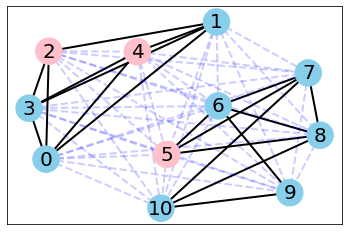

In [14]:
import networkx as nx
import itertools
def get_most_likely_topic(doc):
    bow = model.id2word.doc2bow(doc)
    topics, probabilities = zip(*model.get_document_topics(bow))
    max_p = max(probabilities)
    topic = topics[probabilities.index(max_p)]
    return topic

def get_node_color(i):
    return 'skyblue' if get_most_likely_topic(texts[i]) == 0 else 'pink'

G = nx.Graph()
for i, _ in enumerate(texts):
    G.add_node(i)

for (i1, i2) in itertools.combinations(range(len(texts)), 2):
    bow1, bow2 = texts[i1], texts[i2]
    distance = jaccard(bow1, bow2)
    G.add_edge(i1, i2, weight=1/distance)

#
# https://networkx.github.io/documentation/networkx-1.9/examples/drawing/weighted_graph.html
#
pos = nx.spring_layout(G)

threshold = 1.25
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > threshold]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= threshold]

node_colors = [get_node_color(i) for (i, _) in enumerate(texts)]
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
nx.draw_networkx_edges(G,pos,edgelist=elarge, width=2)
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=2, alpha=0.2, edge_color='b', style='dashed')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

We can make several observations from this graph.

First, the graph consists of two connected components (if you ignore the weak edges). Nodes 0, 1, 2, 3, 4 (which all belong to the water topic) form the first connected component. The other nodes, which all belong to the finance topic, form the second connected component.

Second, the LDA model didn’t do a very good job of classifying our documents into topics. There were many misclassifications, as you can confirm in the summary below:

In [13]:
print('id\ttopic\tdoc')
for i, t in enumerate(texts):
    print('%d\t%d\t%s' % (i, get_most_likely_topic(t), ' '.join(t)))

id	topic	doc
0	0	bank river shore water
1	0	river water flow fast tree
2	1	bank water fall flow
3	0	bank bank water rain river
4	1	river water mud tree
5	1	money transaction bank finance
6	0	bank borrow money
7	0	bank finance
8	0	finance money sell bank
9	0	borrow sell
10	0	bank loan sell
